In [9]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pandas_ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, RobustScaler
import yfinance as yf

In [10]:
name = 'AAPL'
train_end_date = '2022-01-01'

In [11]:
_ohlc_df = yf.download(name, start='2012-01-01', end=train_end_date)
xom_ohlc_df = yf.download('XOM', start='2012-01-01', end=train_end_date)
shw_ohlc_df = yf.download('SHW', start='2012-01-01', end=train_end_date)
unp_ohlc_df = yf.download('UNP', start='2012-01-01', end=train_end_date)
nee_ohlc_df = yf.download('NEE', start='2012-01-01', end=train_end_date)
pfe_ohlc_df = yf.download('PFE', start='2012-01-01', end=train_end_date)
jpm_ohlc_df = yf.download('JPM', start='2012-01-01', end=train_end_date)
amzn_ohlc_df = yf.download('AMZN', start='2012-01-01', end=train_end_date)
pg_ohlc_df = yf.download('PG', start='2012-01-01', end=train_end_date)
aapl_ohlc_df = yf.download('AAPL', start='2012-01-01', end=train_end_date)
goog_ohlc_df = yf.download('GOOG', start='2012-01-01', end=train_end_date)

cvx_ohlc_df = yf.download('CVX', start='2012-01-01', end=train_end_date)
nem_ohlc_df = yf.download('NEM', start='2012-01-01', end=train_end_date)
rtx_ohlc_df = yf.download('RTX', start='2012-01-01', end=train_end_date)
duk_ohlc_df = yf.download('DUK', start='2012-01-01', end=train_end_date)
lly_ohlc_df = yf.download('LLY', start='2012-01-01', end=train_end_date)
wfc_ohlc_df = yf.download('WFC', start='2012-01-01', end=train_end_date)
tsla_ohlc_df = yf.download('TSLA', start='2012-01-01', end=train_end_date)
ko_ohlc_df = yf.download('KO', start='2012-01-01', end=train_end_date)
msft_ohlc_df = yf.download('MSFT', start='2012-01-01', end=train_end_date)
dis_ohlc_df = yf.download('DIS', start='2012-01-01', end=train_end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
def get_all_indicators(datafr):
    datafr['1d_close_pct'] = datafr['Close'].pct_change(1)
    datafr['3d_close_pct'] = datafr['Close'].pct_change(3)
    datafr['5d_close_pct'] = datafr['Close'].pct_change(5)
    datafr['10d_close_pct'] = datafr['Close'].pct_change(10)

    datafr['10d_volatility'] = datafr['Close'].rolling(window=10).std()
    tr_df = pd.DataFrame()
    tr_df['High-Low'] = datafr['High'] - datafr['Low']
    tr_df['High-ClosePrev'] = abs(datafr['High'] - datafr['Close'].shift(1))
    tr_df['Low-ClosePrev'] = abs(datafr['Low'] - datafr['Close'].shift(1))
    datafr['TR'] = tr_df[['High-Low', 'High-ClosePrev', 'Low-ClosePrev']].max(axis=1)
    datafr['ATR10'] = datafr['TR'].rolling(window=10).mean()
    datafr['WATR'] = datafr['TR'].rolling(window=14).apply(lambda x: np.average(x, weights=np.arange(1, 14 + 1))) # Weighted Average True Range (WATR)

    log_returns = np.log(datafr['Close']/datafr['Close'].shift(1))
    datafr['VOL'] = log_returns.fillna(0).rolling(window=10).std()*np.sqrt(10) #assuming 252 trading days a year #now we just care about 10
    datafr['VS'] = np.log(datafr['High']) - np.log(datafr['Low'])
    datafr['VP'] = 0.361 * (np.log(datafr['High']/datafr['Low']))**2
    datafr['VGK'] = 0.5 * (np.log(datafr['High'])-np.log(datafr['Low']))**2 - (2*np.log(2)-1)*(np.log(datafr['Close'])-np.log(datafr['Open']))**2
    datafr['VRS'] = (np.log(datafr['High'])-np.log(datafr['Open']))*(np.log(datafr['High'])-np.log(datafr['Close'])) - (np.log(datafr['Low'])-np.log(datafr['Open']))*(np.log(datafr['Low'])-np.log(datafr['Close']))

    datafr['SMA20'] = datafr.Close.rolling(20).mean()
    datafr['EMA20'] = datafr.Close.ewm(span=20).mean()
    datafr['SMA100'] = datafr.Close.rolling(100).mean()
    datafr['EMA100'] = datafr.Close.ewm(span=100).mean()

    datafr['Open_SMA50_diff'] = datafr['Open'].sub(datafr['SMA20'])
    datafr['Open_EMA20_diff'] = datafr['Open'].sub(datafr['EMA20'])
    datafr['Open_SMA100_diff'] = datafr['Open'].sub(datafr['SMA100'])
    datafr['Open_EMA100_diff'] = datafr['Open'].sub(datafr['EMA100'])

    #pandas ta library
    datafr['RSI_14'] = pandas_ta.rsi(datafr['Close'],length=14)
    datafr['RSI_100'] = pandas_ta.rsi(datafr['Close'],length=100)

    vor_df = pandas_ta.vortex(datafr['High'],datafr['Low'],datafr['Close'],14)
    datafr['VTXP_14'] = vor_df['VTXP_14']
    datafr['VTXM_14'] = vor_df['VTXM_14']
    stoch_df = pandas_ta.stoch(datafr['High'],datafr['Low'],datafr['Close'],k=14,d=26)
    datafr['STOCHk_14_26_3'] = stoch_df['STOCHk_14_26_3']
    datafr['STOCHd_14_26_3'] = stoch_df['STOCHd_14_26_3']
    adx_df = pandas_ta.adx(datafr['High'],datafr['Low'],datafr['Close'],length=14)#average directional index
    datafr['ADX_14'] = adx_df['ADX_14']
    datafr['DMP_14'] = adx_df['DMP_14']
    datafr['DMN_14'] = adx_df['DMN_14']
    amat_df = pandas_ta.amat(datafr['Close']) #Archer Moving Averages Trends
    datafr['AMATe_LR_8_21_2'] = amat_df['AMATe_LR_8_21_2']
    datafr['AMATe_SR_8_21_2'] = amat_df['AMATe_SR_8_21_2']
    aroon_df = pandas_ta.aroon(datafr['High'],datafr['Low']) #Aroon & Aroon Oscillator
    datafr['AROOND_14'] = aroon_df['AROOND_14']
    datafr['AROONU_14'] = aroon_df['AROONU_14']
    datafr['AROONOSC_14'] = aroon_df['AROONOSC_14']
    ao_df = pandas_ta.ao(datafr['High'],datafr['Low'])#Awesome Oscillator
    datafr['AO_5_34'] = ao_df
    uo_df = pandas_ta.uo(datafr['High'],datafr['Low'],datafr['Close'])#Ultimate Oscillator
    datafr['UO_7_14_28'] = uo_df
    cg_df = pandas_ta.cg(datafr['Close'])#Center of Gravity
    datafr['CG_10'] = cg_df
    coppock_df = pandas_ta.coppock(datafr['Close'])#Coppock
    datafr['COPC_11_14_10'] = coppock_df
    inertia_df = pandas_ta.inertia(datafr['Close'],datafr['High'],datafr['Low'])#inertia
    datafr['INERTIA_20_14'] = inertia_df
    stc_df = pandas_ta.stc(datafr['Close']) #schaff trend cycle
    datafr['STC_10_12_26_0.5'] = stc_df['STC_10_12_26_0.5']
    datafr['STCmacd_10_12_26_0.5'] = stc_df['STCmacd_10_12_26_0.5']
    datafr['STCstoch_10_12_26_0.5'] = stc_df['STCstoch_10_12_26_0.5']
    tsi_df = pandas_ta.tsi(datafr['Close']) # true strength index
    datafr['TSI_13_25_13'] = tsi_df['TSI_13_25_13']
    qstick_df = pandas_ta.qstick(datafr['Open'],datafr['Close']) #q stick indicator
    datafr['QS_10'] = qstick_df
    vhf_df = pandas_ta.vhf(datafr['Close'])#vertical horizontal filter
    datafr['VHF_28'] = vhf_df
    dpo_df = pandas_ta.dpo(datafr['Close']) #detrend price oscillator
    datafr['DPO_20'] = dpo_df
    pdist_df = pandas_ta.pdist(datafr['Open'],datafr['High'],datafr['Low'],datafr['Close'])
    datafr['PDIST'] = pdist_df
    rvi_df = pandas_ta.rvi(datafr['Close'],datafr['High'],datafr['Low']) #relative volatility index
    datafr['RVI_14'] = rvi_df
    willr_df = pandas_ta.willr(datafr['High'],datafr['Low'],datafr['Close']) # William's Percent R (WILLR)
    datafr['WILLR_14'] = willr_df
    ebsw_df = pandas_ta.ebsw(datafr['Close']) #Even Better SineWave (EBSW)
    datafr['EBSW_40_10'] = ebsw_df
    kurt_df = pandas_ta.kurtosis(datafr['Close']) #kurtosis
    datafr['KURT_30'] = kurt_df
    zscore_df = pandas_ta.zscore(datafr['Close'])
    datafr['ZS_30'] = zscore_df
    chop_df = pandas_ta.chop(datafr['High'],datafr['Low'],datafr['Close']) #choppiness index
    datafr['CHOP_14_1_100'] = chop_df

    print(datafr.shape)
    datafr = datafr.dropna()
    print(datafr.shape)

    return datafr

In [13]:

_ohlc_df = get_all_indicators(_ohlc_df)
xom_ohlc_df = get_all_indicators(xom_ohlc_df)
shw_ohlc_df = get_all_indicators(shw_ohlc_df)
unp_ohlc_df = get_all_indicators(unp_ohlc_df)
nee_ohlc_df = get_all_indicators(nee_ohlc_df)
pfe_ohlc_df = get_all_indicators(pfe_ohlc_df)
jpm_ohlc_df = get_all_indicators(jpm_ohlc_df)
amzn_ohlc_df = get_all_indicators(amzn_ohlc_df)
pg_ohlc_df = get_all_indicators(pg_ohlc_df)
aapl_ohlc_df = get_all_indicators(aapl_ohlc_df)
goog_ohlc_df = get_all_indicators(goog_ohlc_df)


cvx_ohlc_df = get_all_indicators(cvx_ohlc_df)
nem_ohlc_df = get_all_indicators(nem_ohlc_df)
rtx_ohlc_df = get_all_indicators(rtx_ohlc_df)
duk_ohlc_df = get_all_indicators(duk_ohlc_df)
lly_ohlc_df = get_all_indicators(lly_ohlc_df)
wfc_ohlc_df = get_all_indicators(wfc_ohlc_df)
tsla_ohlc_df = get_all_indicators(tsla_ohlc_df)
ko_ohlc_df = get_all_indicators(ko_ohlc_df)
msft_ohlc_df = get_all_indicators(msft_ohlc_df)
dis_ohlc_df = get_all_indicators(dis_ohlc_df)

(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)
(2517, 60)
(2406, 60)


In [14]:
def prepare_dataframe(df,cols_to_use,close_col_idx=3):
    updated_df = df.copy()

    updated_df = updated_df[cols_to_use] 
    upd_scaler = StandardScaler()
    upd_scaler = upd_scaler.fit(updated_df)
    updated_df_scaled = upd_scaler.transform(updated_df)

    X = []
    Y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    global n_past
    n_past = 14  # Number of past days we want to use to predict the future.
    for i in range(n_past, len(updated_df_scaled) - n_future + 1,n_future):
        X.append(updated_df_scaled[i - n_past:i, 0:updated_df_scaled.shape[1]])
        Y.append(updated_df_scaled[i + n_future - 1:i + n_future, close_col_idx]) #index 0 is Open, 3 is Close
        # Y.append(updated_df_scaled[i:i + n_future, 0]) #index 0 is Open

    return np.array(X), np.array(Y), upd_scaler

In [15]:
cols = list(_ohlc_df)
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Clos

df_for_training1 = _ohlc_df[cols].astype(float) 
df_for_training2 = xom_ohlc_df[cols].astype(float) 
df_for_training3 = shw_ohlc_df[cols].astype(float) 
df_for_training4 = unp_ohlc_df[cols].astype(float) 
df_for_training5 = nee_ohlc_df[cols].astype(float) 
df_for_training6 = pfe_ohlc_df[cols].astype(float) 
df_for_training7 = jpm_ohlc_df[cols].astype(float) 
df_for_training8 = amzn_ohlc_df[cols].astype(float) 
df_for_training9 = pg_ohlc_df[cols].astype(float) 
df_for_training10 = aapl_ohlc_df[cols].astype(float) 
df_for_training11 = goog_ohlc_df[cols].astype(float) 

df_for_training12 = cvx_ohlc_df[cols].astype(float)
df_for_training13 = nem_ohlc_df[cols].astype(float)
df_for_training14 = rtx_ohlc_df[cols].astype(float)
df_for_training15 = duk_ohlc_df[cols].astype(float)
df_for_training16 = lly_ohlc_df[cols].astype(float)
df_for_training17 = wfc_ohlc_df[cols].astype(float)
df_for_training18 = tsla_ohlc_df[cols].astype(float)
df_for_training19 = ko_ohlc_df[cols].astype(float)
df_for_training20 = msft_ohlc_df[cols].astype(float)
df_for_training21 = dis_ohlc_df[cols].astype(float)


columns_to_use_1 = ['Close']
trainX1_1, trainY1_1, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_1,0)
trainX2_1, trainY2_1, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_1,0)
trainX3_1, trainY3_1, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_1,0)
trainX4_1, trainY4_1, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_1,0)
trainX5_1, trainY5_1, train_scaler = prepare_dataframe(df_for_training5,columns_to_use_1,0)
trainX6_1, trainY6_1, train_scaler = prepare_dataframe(df_for_training6,columns_to_use_1,0)
trainX7_1, trainY7_1, train_scaler = prepare_dataframe(df_for_training7,columns_to_use_1,0)
trainX8_1, trainY8_1, train_scaler = prepare_dataframe(df_for_training8,columns_to_use_1,0)
trainX9_1, trainY9_1, train_scaler = prepare_dataframe(df_for_training9,columns_to_use_1,0)
trainX10_1, trainY10_1, train_scaler = prepare_dataframe(df_for_training10,columns_to_use_1,0)
trainX11_1, trainY11_1, train_scaler = prepare_dataframe(df_for_training11,columns_to_use_1,0)

trainX12_1, trainY12_1, train_scaler = prepare_dataframe(df_for_training12,columns_to_use_1,0)
trainX13_1, trainY13_1, train_scaler = prepare_dataframe(df_for_training13,columns_to_use_1,0)
trainX14_1, trainY14_1, train_scaler = prepare_dataframe(df_for_training14,columns_to_use_1,0)
trainX15_1, trainY15_1, train_scaler = prepare_dataframe(df_for_training15,columns_to_use_1,0)
trainX16_1, trainY16_1, train_scaler = prepare_dataframe(df_for_training16,columns_to_use_1,0)
trainX17_1, trainY17_1, train_scaler = prepare_dataframe(df_for_training17,columns_to_use_1,0)
trainX18_1, trainY18_1, train_scaler = prepare_dataframe(df_for_training18,columns_to_use_1,0)
trainX19_1, trainY19_1, train_scaler = prepare_dataframe(df_for_training19,columns_to_use_1,0)
trainX20_1, trainY20_1, train_scaler = prepare_dataframe(df_for_training20,columns_to_use_1,0)
trainX21_1, trainY21_1, train_scaler = prepare_dataframe(df_for_training21,columns_to_use_1,0)


columns_to_use_2 = ['Close', 'ATR10']
trainX1_2, trainY1_2, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_2,0)
trainX2_2, trainY2_2, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_2,0)
trainX3_2, trainY3_2, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_2,0)
trainX4_2, trainY4_2, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_2,0)
trainX5_2, trainY5_2, train_scaler = prepare_dataframe(df_for_training5,columns_to_use_2,0)
trainX6_2, trainY6_2, train_scaler = prepare_dataframe(df_for_training6,columns_to_use_2,0)
trainX7_2, trainY7_2, train_scaler = prepare_dataframe(df_for_training7,columns_to_use_2,0)
trainX8_2, trainY8_2, train_scaler = prepare_dataframe(df_for_training8,columns_to_use_2,0)
trainX9_2, trainY9_2, train_scaler = prepare_dataframe(df_for_training9,columns_to_use_2,0)
trainX10_2, trainY10_2, train_scaler = prepare_dataframe(df_for_training10,columns_to_use_2,0)
trainX11_2, trainY11_2, train_scaler = prepare_dataframe(df_for_training11,columns_to_use_2,0)

trainX12_2, trainY12_2, train_scaler = prepare_dataframe(df_for_training12,columns_to_use_2,0)
trainX13_2, trainY13_2, train_scaler = prepare_dataframe(df_for_training13,columns_to_use_2,0)
trainX14_2, trainY14_2, train_scaler = prepare_dataframe(df_for_training14,columns_to_use_2,0)
trainX15_2, trainY15_2, train_scaler = prepare_dataframe(df_for_training15,columns_to_use_2,0)
trainX16_2, trainY16_2, train_scaler = prepare_dataframe(df_for_training16,columns_to_use_2,0)
trainX17_2, trainY17_2, train_scaler = prepare_dataframe(df_for_training17,columns_to_use_2,0)
trainX18_2, trainY18_2, train_scaler = prepare_dataframe(df_for_training18,columns_to_use_2,0)
trainX19_2, trainY19_2, train_scaler = prepare_dataframe(df_for_training19,columns_to_use_2,0)
trainX20_2, trainY20_2, train_scaler = prepare_dataframe(df_for_training20,columns_to_use_2,0)
trainX21_2, trainY21_2, train_scaler = prepare_dataframe(df_for_training21,columns_to_use_2,0)




columns_to_use_5 = ['Open', 'High', 'Low', 'Close', 'Volume']
trainX1_5, trainY1_5, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_5,0)
trainX2_5, trainY2_5, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_5,0)
trainX3_5, trainY3_5, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_5,0)
trainX4_5, trainY4_5, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_5,0)
trainX5_5, trainY5_5, train_scaler = prepare_dataframe(df_for_training5,columns_to_use_5,0)
trainX6_5, trainY6_5, train_scaler = prepare_dataframe(df_for_training6,columns_to_use_5,0)
trainX7_5, trainY7_5, train_scaler = prepare_dataframe(df_for_training7,columns_to_use_5,0)
trainX8_5, trainY8_5, train_scaler = prepare_dataframe(df_for_training8,columns_to_use_5,0)
trainX9_5, trainY9_5, train_scaler = prepare_dataframe(df_for_training9,columns_to_use_5,0)
trainX10_5, trainY10_5, train_scaler = prepare_dataframe(df_for_training10,columns_to_use_5,0)
trainX11_5, trainY11_5, train_scaler = prepare_dataframe(df_for_training11,columns_to_use_5,0)

trainX12_5, trainY12_5, train_scaler = prepare_dataframe(df_for_training12,columns_to_use_5,0)
trainX13_5, trainY13_5, train_scaler = prepare_dataframe(df_for_training13,columns_to_use_5,0)
trainX14_5, trainY14_5, train_scaler = prepare_dataframe(df_for_training14,columns_to_use_5,0)
trainX15_5, trainY15_5, train_scaler = prepare_dataframe(df_for_training15,columns_to_use_5,0)
trainX16_5, trainY16_5, train_scaler = prepare_dataframe(df_for_training16,columns_to_use_5,0)
trainX17_5, trainY17_5, train_scaler = prepare_dataframe(df_for_training17,columns_to_use_5,0)
trainX18_5, trainY18_5, train_scaler = prepare_dataframe(df_for_training18,columns_to_use_5,0)
trainX19_5, trainY19_5, train_scaler = prepare_dataframe(df_for_training19,columns_to_use_5,0)
trainX20_5, trainY20_5, train_scaler = prepare_dataframe(df_for_training20,columns_to_use_5,0)
trainX21_5, trainY21_5, train_scaler = prepare_dataframe(df_for_training21,columns_to_use_5,0)



columns_to_use_7 = ['Close', '1d_close_pct', 'ATR10', 'VOL', 'EMA20', 'PDIST', 'ADX_14']
trainX1_7, trainY1_7, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_7,0)
trainX2_7, trainY2_7, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_7,0)
trainX3_7, trainY3_7, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_7,0)
trainX4_7, trainY4_7, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_7,0)
trainX5_7, trainY5_7, train_scaler = prepare_dataframe(df_for_training5,columns_to_use_7,0)
trainX6_7, trainY6_7, train_scaler = prepare_dataframe(df_for_training6,columns_to_use_7,0)
trainX7_7, trainY7_7, train_scaler = prepare_dataframe(df_for_training7,columns_to_use_7,0)
trainX8_7, trainY8_7, train_scaler = prepare_dataframe(df_for_training8,columns_to_use_7,0)
trainX9_7, trainY9_7, train_scaler = prepare_dataframe(df_for_training9,columns_to_use_7,0)
trainX10_7, trainY10_7, train_scaler = prepare_dataframe(df_for_training10,columns_to_use_7,0)
trainX11_7, trainY11_7, train_scaler = prepare_dataframe(df_for_training11,columns_to_use_7,0)


trainX12_7, trainY12_7, train_scaler = prepare_dataframe(df_for_training12,columns_to_use_7,0)
trainX13_7, trainY13_7, train_scaler = prepare_dataframe(df_for_training13,columns_to_use_7,0)
trainX14_7, trainY14_7, train_scaler = prepare_dataframe(df_for_training14,columns_to_use_7,0)
trainX15_7, trainY15_7, train_scaler = prepare_dataframe(df_for_training15,columns_to_use_7,0)
trainX16_7, trainY16_7, train_scaler = prepare_dataframe(df_for_training16,columns_to_use_7,0)
trainX17_7, trainY17_7, train_scaler = prepare_dataframe(df_for_training17,columns_to_use_7,0)
trainX18_7, trainY18_7, train_scaler = prepare_dataframe(df_for_training18,columns_to_use_7,0)
trainX19_7, trainY19_7, train_scaler = prepare_dataframe(df_for_training19,columns_to_use_7,0)
trainX20_7, trainY20_7, train_scaler = prepare_dataframe(df_for_training20,columns_to_use_7,0)
trainX21_7, trainY21_7, train_scaler = prepare_dataframe(df_for_training21,columns_to_use_7,0)




columns_to_use_max = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1d_close_pct',
       '3d_close_pct', '5d_close_pct', '10d_close_pct', '10d_volatility', 'TR',
       'ATR10', 'WATR', 'VOL', 'VS', 'VP', 'VGK', 'VRS', 'SMA20', 'EMA20', 
       'SMA100', 'EMA100','Open_EMA20_diff', 'Open_SMA100_diff',
       'Open_EMA100_diff', 'RSI_14', 'RSI_100', 'VTXP_14', 'VTXM_14',
       'STOCHk_14_26_3', 'STOCHd_14_26_3', 'ADX_14', 'DMP_14', 'DMN_14',
       'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'AROOND_14', 'AROONU_14',
       'AROONOSC_14', 'AO_5_34',
       'UO_7_14_28', 'CG_10', 'COPC_11_14_10', 'INERTIA_20_14',
       'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5',
       'TSI_13_25_13', 'QS_10', 'VHF_28', 'DPO_20', 'PDIST', 'RVI_14',
       'WILLR_14', 'EBSW_40_10', 'KURT_30', 'ZS_30', 'CHOP_14_1_100']

trainX1_max, trainY1_max, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_max,0)
trainX2_max, trainY2_max, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_max,0)
trainX3_max, trainY3_max, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_max,0)
trainX4_max, trainY4_max, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_max,0)
trainX5_max, trainY5_max, train_scaler = prepare_dataframe(df_for_training5,columns_to_use_max,0)
trainX6_max, trainY6_max, train_scaler = prepare_dataframe(df_for_training6,columns_to_use_max,0)
trainX7_max, trainY7_max, train_scaler = prepare_dataframe(df_for_training7,columns_to_use_max,0)
trainX8_max, trainY8_max, train_scaler = prepare_dataframe(df_for_training8,columns_to_use_max,0)
trainX9_max, trainY9_max, train_scaler = prepare_dataframe(df_for_training9,columns_to_use_max,0)
trainX10_max, trainY10_max, train_scaler = prepare_dataframe(df_for_training10,columns_to_use_max,0)
trainX11_max, trainY11_max, train_scaler = prepare_dataframe(df_for_training11,columns_to_use_max,0)

trainX12_max, trainY12_max, train_scaler = prepare_dataframe(df_for_training12,columns_to_use_max,0)
trainX13_max, trainY13_max, train_scaler = prepare_dataframe(df_for_training13,columns_to_use_max,0)
trainX14_max, trainY14_max, train_scaler = prepare_dataframe(df_for_training14,columns_to_use_max,0)
trainX15_max, trainY15_max, train_scaler = prepare_dataframe(df_for_training15,columns_to_use_max,0)
trainX16_max, trainY16_max, train_scaler = prepare_dataframe(df_for_training16,columns_to_use_max,0)
trainX17_max, trainY17_max, train_scaler = prepare_dataframe(df_for_training17,columns_to_use_max,0)
trainX18_max, trainY18_max, train_scaler = prepare_dataframe(df_for_training18,columns_to_use_max,0)
trainX19_max, trainY19_max, train_scaler = prepare_dataframe(df_for_training19,columns_to_use_max,0)
trainX20_max, trainY20_max, train_scaler = prepare_dataframe(df_for_training20,columns_to_use_max,0)
trainX21_max, trainY21_max, train_scaler = prepare_dataframe(df_for_training21,columns_to_use_max,0)



['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1d_close_pct', '3d_close_pct', '5d_close_pct', '10d_close_pct', '10d_volatility', 'TR', 'ATR10', 'WATR', 'VOL', 'VS', 'VP', 'VGK', 'VRS', 'SMA20', 'EMA20', 'SMA100', 'EMA100', 'Open_SMA50_diff', 'Open_EMA20_diff', 'Open_SMA100_diff', 'Open_EMA100_diff', 'RSI_14', 'RSI_100', 'VTXP_14', 'VTXM_14', 'STOCHk_14_26_3', 'STOCHd_14_26_3', 'ADX_14', 'DMP_14', 'DMN_14', 'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'AO_5_34', 'UO_7_14_28', 'CG_10', 'COPC_11_14_10', 'INERTIA_20_14', 'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5', 'TSI_13_25_13', 'QS_10', 'VHF_28', 'DPO_20', 'PDIST', 'RVI_14', 'WILLR_14', 'EBSW_40_10', 'KURT_30', 'ZS_30', 'CHOP_14_1_100']


In [16]:
def build_lstm_model(input_shape):

    inputs = tf.keras.layers.Input(shape=input_shape)
    lstm_output1 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    dropout_output1 = tf.keras.layers.Dropout(0.3)(lstm_output1)  # Adding dropout with a rate of 0.2
    lstm_output2 = tf.keras.layers.LSTM(128, return_sequences=True)(dropout_output1)
    dropout_output2 = tf.keras.layers.Dropout(0.3)(lstm_output2)  
    lstm_output3 = tf.keras.layers.LSTM(128, return_sequences=False)(dropout_output2)
    dropout_output3 = tf.keras.layers.Dropout(0.3)(lstm_output3)  

    flat_mean_output = tf.keras.layers.Dense(5, activation='relu')(dropout_output3) 
    output_mean = tf.keras.layers.Dense(1)(flat_mean_output)  # Output for mean prediction

    model = tf.keras.models.Model(inputs=inputs, outputs=output_mean)

    return model

In [17]:
#20 stock basket
#use only Close column
model_1 = build_lstm_model(input_shape=(n_past, len(columns_to_use_1)))
model_1.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_1 = np.concatenate((trainX1_1,trainX2_1,trainX3_1,trainX4_1,trainX5_1,trainX6_1,trainX7_1,trainX8_1,trainX9_1,trainX10_1,trainX11_1,
                                trainX12_1,trainX13_1,trainX14_1,trainX15_1,trainX16_1,trainX17_1,trainX18_1,trainX19_1,trainX20_1,trainX21_1),axis=0)
big_train_Y_1 = np.concatenate((trainY1_1,trainY2_1,trainY3_1,trainY4_1,trainY5_1,trainY6_1,trainY7_1,trainY8_1,trainY9_1,trainY10_1,trainY11_1,
                                trainY12_1,trainY13_1,trainY14_1,trainY15_1,trainY16_1,trainY17_1,trainY18_1,trainY19_1,trainY20_1,trainY21_1),axis=0)
history_1 = model_1.fit(big_train_X_1, big_train_Y_1, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [18]:
#20 stock basket
#use Close, ATR10 columns
print(trainX10_2.shape)
model_2 = build_lstm_model(input_shape=(n_past, len(columns_to_use_2)))
model_2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_2 = np.concatenate((trainX1_2,trainX2_2,trainX3_2,trainX4_2,trainX5_2,trainX6_2,trainX7_2,trainX8_2,trainX9_2,trainX10_2,trainX11_2,
                                trainX12_2,trainX13_2,trainX14_2,trainX15_2,trainX16_2,trainX17_2,trainX18_2,trainX19_2,trainX20_2,trainX21_2),axis=0)
big_train_Y_2 = np.concatenate((trainY1_2,trainY2_2,trainY3_2,trainY4_2,trainY5_2,trainY6_2,trainY7_2,trainY8_2,trainY9_2,trainY10_2,trainY11_2,
                                trainY12_2,trainY13_2,trainY14_2,trainY15_2,trainY16_2,trainY17_2,trainY18_2,trainY19_2,trainY20_2,trainY21_2),axis=0)
history_2 = model_2.fit(big_train_X_2, big_train_Y_2, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

(2392, 14, 2)


In [19]:
#20 stock basket
#use OHLCV columns
model_5 = build_lstm_model(input_shape=(n_past, len(columns_to_use_5)))
model_5.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_5 = np.concatenate((trainX1_5,trainX2_5,trainX3_5,trainX4_5,trainX5_5,trainX6_5,trainX7_5,trainX8_5,trainX9_5,trainX10_5,trainX11_5,
                                trainX12_5,trainX13_5,trainX14_5,trainX15_5,trainX16_5,trainX17_5,trainX18_5,trainX19_5,trainX20_5,trainX21_5),axis=0)
big_train_Y_5 = np.concatenate((trainY1_5,trainY2_5,trainY3_5,trainY4_5,trainY5_5,trainY6_5,trainY7_5,trainY8_5,trainY9_5,trainY10_5,trainY11_5,
                                trainY12_5,trainY13_5,trainY14_5,trainY15_5,trainY16_5,trainY17_5,trainY18_5,trainY19_5,trainY20_5,trainY21_5),axis=0)
history_5 = model_5.fit(big_train_X_5, big_train_Y_5, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [20]:
#20 stock basket
#use 7 indics columns
model_7 = build_lstm_model(input_shape=(n_past, len(columns_to_use_7)))
model_7.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_7 = np.concatenate((trainX1_7,trainX2_7,trainX3_7,trainX4_7,trainX5_7,trainX6_7,trainX7_7,trainX8_7,trainX9_7,trainX10_7,trainX11_7,
                                trainX12_7,trainX13_7,trainX14_7,trainX15_7,trainX16_7,trainX17_7,trainX18_7,trainX19_7,trainX20_7,trainX21_7),axis=0)
big_train_Y_7 = np.concatenate((trainY1_7,trainY2_7,trainY3_7,trainY4_7,trainY5_7,trainY6_7,trainY7_7,trainY8_7,trainY9_7,trainY10_7,trainY11_7,
                                trainY12_7,trainY13_7,trainY14_7,trainY15_7,trainY16_7,trainY17_7,trainY18_7,trainY19_7,trainY20_7,trainY21_7),axis=0)
history_7 = model_7.fit(big_train_X_7, big_train_Y_7, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [21]:
#20 stock basket
#use OHLCV column
model_max = build_lstm_model(input_shape=(n_past, len(columns_to_use_max)))
model_max.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_max = np.concatenate((trainX1_max,trainX2_max,trainX3_max,trainX4_max,trainX5_max,trainX6_max,trainX7_max,trainX8_max,trainX9_max,trainX10_max,trainX11_max,
                                trainX12_max,trainX13_max,trainX14_max,trainX15_max,trainX16_max,trainX17_max,trainX18_max,trainX19_max,trainX20_max,trainX21_max),axis=0)
big_train_Y_max = np.concatenate((trainY1_max,trainY2_max,trainY3_max,trainY4_max,trainY5_max,trainY6_max,trainY7_max,trainY8_max,trainY9_max,trainY10_max,trainY11_max,
                                trainY12_max,trainY13_max,trainY14_max,trainY15_max,trainY16_max,trainY17_max,trainY18_max,trainY19_max,trainY20_max,trainY21_max),axis=0)
history_max = model_max.fit(big_train_X_max, big_train_Y_max, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

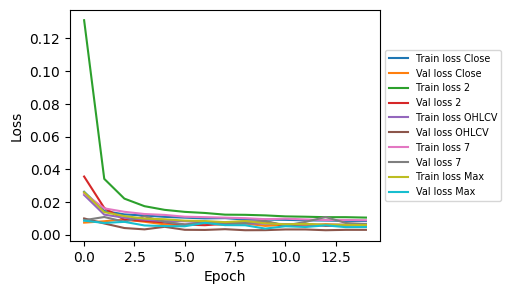

In [23]:
plt.figure(figsize=(4,3))

plt.plot(history_1.history['loss'], label='Train loss Close')
plt.plot(history_1.history['val_loss'], label='Val loss Close')
plt.plot(history_2.history['loss'], label='Train loss 2')
plt.plot(history_2.history['val_loss'], label='Val loss 2')
plt.plot(history_5.history['loss'], label='Train loss OHLCV')
plt.plot(history_5.history['val_loss'], label='Val loss OHLCV')
plt.plot(history_7.history['loss'], label='Train loss 7')
plt.plot(history_7.history['val_loss'], label='Val loss 7')
plt.plot(history_max.history['loss'], label='Train loss Max')
plt.plot(history_max.history['val_loss'], label='Val loss Max')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
plt.show()

In [24]:
# train_end_date = '2017-12-31'
print(train_end_date)
forecast_df = yf.download(name, start=train_end_date, end='2023-07-01')
forecast_df = forecast_df.reset_index().rename(columns={'index': 'Date'})

2022-01-01
[*********************100%***********************]  1 of 1 completed


In [25]:
forecast_df = get_all_indicators(forecast_df)

(375, 61)
(264, 61)


In [26]:
forecast_date_array = forecast_df['Date'].to_numpy()[n_past:]
truth_closes = forecast_df['Close'].values[n_past:]
truth_sma = forecast_df['SMA20'].values[n_past:]
truth_vs = forecast_df['TR'].values[n_past:]

testX_1, testY_1, scaler_1 = prepare_dataframe(forecast_df,columns_to_use_1,0)
testX_2, testY_2, scaler_2 = prepare_dataframe(forecast_df,columns_to_use_2,0)
testX_5, testY_5, scaler_5 = prepare_dataframe(forecast_df,columns_to_use_5)
testX_7, testY_7, scaler_7 = prepare_dataframe(forecast_df,columns_to_use_7,0)
testX_max, testY_max, scaler_max = prepare_dataframe(forecast_df,columns_to_use_max)

#predict using the Close column only
forecast_1 = model_1.predict(testX_1)
y_pred_1 = scaler_1.inverse_transform(forecast_1)[:,0]

#predict using the Close, ATR10 columns
forecast_2 = model_2.predict(testX_2)
copy_2 = np.repeat(forecast_2,len(columns_to_use_2),axis=-1)
y_pred_2 = scaler_2.inverse_transform(copy_2)[:,0]

#predict using the OHLCV columns
forecast_5 = model_5.predict(testX_5)
copy_5 = np.repeat(forecast_5,len(columns_to_use_5),axis=-1)
y_pred_5 = scaler_5.inverse_transform(copy_5)[:,3]

#predict using the 7 columns
forecast_7 = model_7.predict(testX_7)
copy_7 = np.repeat(forecast_7,len(columns_to_use_7),axis=-1)
y_pred_7 = scaler_7.inverse_transform(copy_7)[:,0]

#predict using the 7 columns
forecast_max = model_max.predict(testX_max)
copy_max = np.repeat(forecast_max,len(columns_to_use_max),axis=-1)
y_pred_max = scaler_max.inverse_transform(copy_max)[:,3]


print(y_pred_1.shape,y_pred_2.shape,y_pred_5.shape,y_pred_7.shape,y_pred_max.shape)

prediction_df = pd.DataFrame({'Date':forecast_date_array,'Close':truth_closes, 'SMA20':truth_sma,
                              'Close_pred_1':y_pred_1, 'Close_pred_2':y_pred_2,
                              'Close_pred_5':y_pred_5,'Close_pred_7':y_pred_7, 
                              'Close_pred_max':y_pred_max})

8/8 [==============================] - 0s 7ms/step
(250,) (250,) (250,) (250,) (250,)


In [27]:
prediction_df.tail()

,Date,Close,SMA20,Close_pred_1,Close_pred_2,Close_pred_5,Close_pred_7,Close_pred_max
245,2023-06-08,180.570007,175.607502,177.839035,177.735779,178.499710,178.664032,178.074829
246,2023-06-09,180.960007,175.968002,178.929764,179.708603,180.201996,180.317413,179.292419
247,2023-06-12,183.789993,176.529002,179.880341,180.026581,180.591858,180.713104,180.041824
248,2023-06-13,183.309998,177.091001,181.956390,182.185577,183.429764,182.713776,181.358932
249,2023-06-14,183.949997,177.685001,182.657227,182.052200,182.451736,182.934418,181.243973


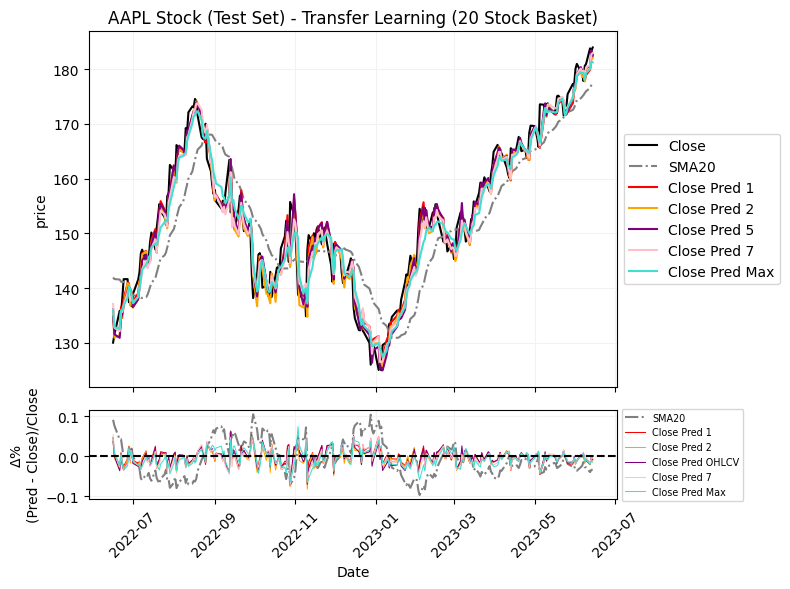

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')
ax[0].plot(prediction_df.Date,prediction_df.SMA20,ls='-.',label='SMA20',color='grey')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_1,label=f'Close Pred 1',color='red')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_2,label=f'Close Pred 2',color='orange')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_5,label=f'Close Pred 5',color='purple')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_7,label=f'Close Pred 7',color='pink')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_max,label=f'Close Pred Max',color='turquoise')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set) - Transfer Learning (20 Stock Basket)')
ax[0].grid(color="0.95")

ax[1].plot(prediction_df.Date, (prediction_df.SMA20 - prediction_df.Close)/prediction_df.Close, color='grey',label='SMA20',ls='-.')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_1- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 1',lw=0.75,color='red')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_2- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 2',lw=0.75,color='orange')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_5- prediction_df.Close)/prediction_df.Close,label=f'Close Pred OHLCV',lw=0.75,color='purple')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_7 - prediction_df.Close)/prediction_df.Close,label='Close Pred 7',lw=0.75,color='pink')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_max - prediction_df.Close)/prediction_df.Close,label='Close Pred Max',lw=0.75,color='turquoise')
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('$\Delta$%\n(Pred - Close)/Close')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
# ax[1].set_xlim(prediction_df.Date.iloc[470],prediction_df.Date.iloc[-1])
# ax[0].set_ylim(110,185)
plt.tight_layout()
plt.show()

250


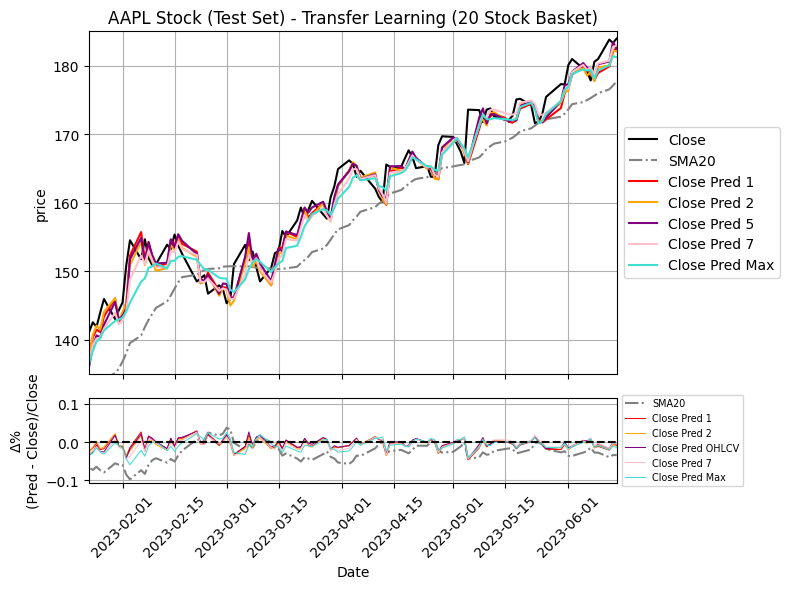

In [33]:
print(len(prediction_df))
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')
ax[0].plot(prediction_df.Date,prediction_df.SMA20,ls='-.',label='SMA20',color='grey')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_1,label=f'Close Pred 1',color='red')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_2,label=f'Close Pred 2',color='orange')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_5,label=f'Close Pred 5',color='purple')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_7,label=f'Close Pred 7',color='pink')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_max,label=f'Close Pred Max',color='turquoise')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set) - Transfer Learning (20 Stock Basket)')
ax[0].grid()

ax[1].plot(prediction_df.Date, (prediction_df.SMA20 - prediction_df.Close)/prediction_df.Close, color='grey',label='SMA20',ls='-.')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_1- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 1',lw=0.75,color='red')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_2- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 2',lw=0.75,color='orange')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_5- prediction_df.Close)/prediction_df.Close,label=f'Close Pred OHLCV',lw=0.75,color='purple')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_7 - prediction_df.Close)/prediction_df.Close,label='Close Pred 7',lw=0.75,color='pink')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_max - prediction_df.Close)/prediction_df.Close,label='Close Pred Max',lw=0.75,color='turquoise')
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('$\Delta$%\n(Pred - Close)/Close')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
ax[1].set_xlim(prediction_df.Date.iloc[150],prediction_df.Date.iloc[-1])
ax[0].set_ylim(135,185)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mape(true_data, forecast_data):
    absolute_percentage_errors = np.abs((true_data - forecast_data) / true_data)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

def calculate_rmse(true_data, forecast_data):
    rmse = np.sqrt(mean_squared_error(true_data, forecast_data))
    return rmse

def calculate_mae(true_data, forecast_data):
    mae = mean_absolute_error(true_data, forecast_data)
    return mae

def calculate_r2(true_data, forecast_data):
    r2 = r2_score(true_data, forecast_data)
    return r2

def calculate_forecast_bias(true_data, forecast_data):
    forecast_bias = np.mean(forecast_data - true_data)
    return forecast_bias


truths = prediction_df.Close.shift(-1).values[:-1]
preds_1 = prediction_df.Close_pred_1.values[:-1]
preds_2 = prediction_df.Close_pred_2.values[:-1]
preds_5 = prediction_df.Close_pred_5.values[:-1]
preds_7 = prediction_df.Close_pred_7.values[:-1]
preds_max = prediction_df.Close_pred_max.values[:-1]

In [31]:
models = {
    "Close Column": preds_1,
    "2 Columns": preds_2,
    "5 Columns": preds_5,
    "7 Columns": preds_7,
    "All Columns": preds_max
}

metrics = ["MAPE", "RMSE", "MAE", "FB", "R2"]


print("{:<15}".format("Model"), end="")
for metric in metrics:
    print("{:<10}".format(metric), end="")
print()

for model_name, predictions in models.items():
    print("{:<15}".format(model_name), end="")
    for metric in metrics:
        metric_value = None
        if metric == "MAPE":
            metric_value = calculate_mape(predictions, truths)
        elif metric == "RMSE":
            metric_value = calculate_rmse(predictions, truths)
        elif metric == "MAE":
            metric_value = calculate_mae(predictions, truths)
        elif metric == "FB":
            metric_value = calculate_forecast_bias(predictions, truths)
        elif metric == "R2":
            metric_value = calculate_r2(predictions, truths)
        print("{:<10.2f}".format(metric_value), end="")
    print()

Model          MAPE      RMSE      MAE       FB        R2        
Close Column   2.06      3.94      3.11      0.42      0.91      
2 Columns      2.07      3.98      3.10      0.97      0.91      
5 Columns      2.11      3.99      3.16      0.60      0.91      
7 Columns      2.13      3.97      3.19      0.86      0.91      
All Columns    2.23      4.09      3.35      0.96      0.90      
